# Random Forest Classifier (BERT-Boosted) x Toxic Content Detection
Il presente Notebook mostra l'addestramento ed il testing di un Classificatore basato su Random Forest per il task di Toxic Content Detection.

I dati sono stati processati come segue:
1. Pulizia del testo (si veda 'dataset_preprocessing.py')
2. Estrazione delle Features mediante BERT (si veda 'feature_extraction_bert_windows.ipynb'/'feature_extraction_bert_mac.ipynb')

In [1]:
import pandas as pd
import numpy as np
import pickle
import nltk
import re
import torch
import matplotlib.pyplot as plt
from transformers import DistilBertTokenizer, DistilBertModel
from nltk.tokenize import word_tokenize
from sklearn.ensemble import RandomForestClassifier
from datetime import datetime
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

e:\anaconda3\envs\DLProjectCUDA\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


All'interno del Notebook sarà addestrato un Classificatore RandomForest con 1000 Alberi.

## Funzioni di Supporto

In [2]:
# Pulizia della Frase
def clean_phrases(phrases):
    new_phrases = list()
    for phrase in phrases:
        # Rimozione di "\r" e "\n"
        phrase = re.sub(r'[\r\n]+', '', phrase)
        # Rimozione di sequenze di ":" (esempio, "::::")
        phrase = re.sub(r'::+', '', phrase)
        # Rimozione di sequenze di "=" (esempio, "====")
        phrase = re.sub(r'==+', '', phrase)
        # Rimozione di sequenze di "*" (esempio, "**")
        phrase = re.sub(r'\*\*+', '', phrase)
        # Rimozione di sequenze numeriche in formato di indirizzi IP (esempio, "192.168.1.1")
        phrase = re.sub(r'\b(?:\d{1,3}\.){3}\d{1,3}\b', '', phrase)
        # Rimozione di contenuto compreso tra Parentesi Quadre (esempio, "[contentContent]")
        phrase = re.sub(r'\[[^\[\]]+\]', '', phrase)
        # Rimozione di Apici, sia singoli che doppi
        phrase = re.sub(r"['\"]", "", phrase)

        ## La rimozione di particolari caratteri o sequenze di caratteri può portare alla fusione di due token diversi

        # Splitting di token in cui compare un segno di interpuzione forte ("?", "!" e ".") seguito da una lettera maiuscola
        phrase = re.sub(r'([?!\.])([A-Z]\w*)', r'\1 \2', phrase)
        # Splitting di parole fuse (esempio, "parolaParola" diventa "parola Parola")
        phrase = re.sub(r'([a-z])([A-Z])', r'\1 \2', phrase)

        tokens = word_tokenize(phrase)
        lowercase_tokens = [token.lower() for token in tokens if token.isalpha()]
        new_phrases.append(' '.join(lowercase_tokens))
    
    return new_phrases

In [3]:
# Carica il tokenizer e il modello preaddestrato di BERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

In [4]:
# Definizione di una funzione per estrarre le caratteristiche di un testo utilizzando BERT
def extract_features(strings):
    # return_tensors ritorna il tensore per la versione pytorch
    # padding = true fa in modo che frasi di lunghezza diversa vengono portate alla lunghezza massima
    inputs = tokenizer(strings, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    last_hidden_states = outputs.last_hidden_state
    #rappresentazione media e unidimensionale delle caratteristiche estratte
    features = torch.mean(last_hidden_states, dim=1).squeeze()
    features = features.numpy()
    return pd.DataFrame(features)

# RandomForest_1000

## Addestramento

In [5]:
training_set = pd.read_csv("./../../datasets/training_set.csv")
print("Numero di Frasi nel Training Set:", len(training_set))
print("Numero Frasi 'toxic' nel Training Set:", len(training_set[training_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Training Set:", len(training_set[training_set['toxic'] == 0]))

Numero di Frasi nel Training Set: 15282
Numero Frasi 'toxic' nel Training Set: 3058
Numero Frasi 'not-toxic' nel Training Set: 12224


In [6]:
y_train = training_set['toxic']

In [7]:
X_train = pd.read_csv("./../../datasets/X_train_bert.csv")
print("X_train.shape", X_train.shape)

X_train.shape (15282, 768)


In [8]:
cl = RandomForestClassifier(n_estimators=1000, random_state=24, verbose=1)
model_filename = "rf_classifier_1000.pkl"

In [9]:
# Addestramento sul Dataset non-lemmatizzato
print("Training di RF_1000 sul Dataset elaborato con BERT...")
start = datetime.now()
cl.fit(X=X_train, y=y_train)
end = datetime.now()
print("Training completato! Tempo impiegato: " + str(end-start))

with open(model_filename, 'wb') as f:
    pickle.dump(cl, f)

Training di RF_1000 sul Dataset elaborato con BERT...


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   21.4s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:  1.5min
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:  3.3min
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:  5.8min


Training completato! Tempo impiegato: 0:07:12.597020


In [10]:
# Caricamento del Modello pre-addestrato
with open(model_filename, 'rb') as f:
    cl = pickle.load(f)

## Testing

In [11]:
test_data = pd.read_csv("./../../datasets/test_set.csv")
test_data.dropna(inplace=True)

test_set = test_data[test_data['toxic'] != -1]
exp_set = test_data[test_data['toxic'] == -1]

print("Numero di Frasi nel Test Set:", len(test_set))
print("Numero Frasi 'toxic' nel Test Set:", len(test_set[test_set['toxic'] == 1]))
print("Numero Frasi 'not-toxic' nel Test Set:", len(test_set[test_set['toxic'] == 0]))

Numero di Frasi nel Test Set: 63842
Numero Frasi 'toxic' nel Test Set: 6087
Numero Frasi 'not-toxic' nel Test Set: 57755


In [12]:
X_test = pd.read_csv("./../../datasets/X_test_bert.csv")
print("X_test.shape:", X_test.shape)
y_test = test_set['toxic']

X_test.shape: (63842, 768)


In [13]:
y_pred = cl.predict(X_test)
print("Accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Precision: " + str(precision_score(y_test, y_pred)))
print("Recall: " + str(recall_score(y_test, y_pred)))
print("F-Measure: " + str(f1_score(y_test, y_pred)))

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.5s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    2.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    5.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    9.0s


Accuracy: 0.9211020957990038
Precision: 0.5870358090185677
Recall: 0.5817315590602924
F-Measure: 0.5843716478257281


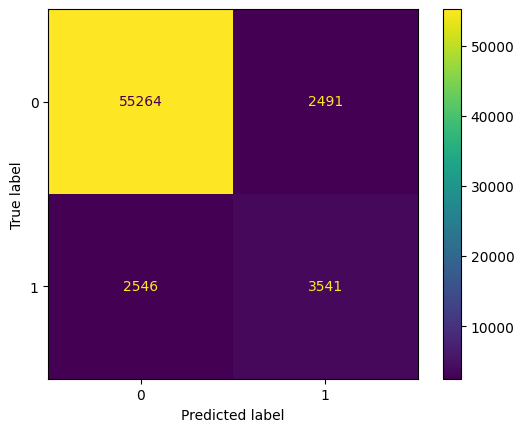

In [14]:
cm = confusion_matrix(y_test, y_pred, labels=cl.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cl.classes_)
disp.plot()
plt.show()

## Generazione delle Explanations

In [15]:
# Utilizzare exp_set -> da vettorizzare con 'vectorizer' e sottoporre a 'cl'
# Implementare LIME